In [5]:
# Load the necessary libraries
import numpy as np
import cupy as cp
# import numpy.random as random
import matplotlib.pyplot as plt
import pickle, gzip, urllib.request, json
from datetime import datetime
from IPython.core.debugger import Pdb # I encourage you to use the degubber, rather than print statements!

import csv
import nltk as nltk
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('tokenizers/wordnet')
except LookupError:
    nltk.download('punkt')
    nltk.download('wordnet')
import string
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer      
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

if cp.is_available() and cp.cuda.is_available():
    import cupy as cnp
else:
    import numpy as cnp
    

[nltk_data] Downloading package punkt to /home/felis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/felis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
# check if the device running this code will have cuda and cupy available for GPU acceleration.
print(cp.is_available())
print(cp.cuda.is_available())

True
True


In [7]:
# Helper function text preprocessing

# The function for lemmatizing, used inside tfidfvectorizer
def tokenize_lemma_removepunc(text:str) -> list[str]:
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    tokens_no_punc = [word for word in tokens if word not in string.punctuation]
    lemmas = [lemmatizer.lemmatize(token) for token in tokens_no_punc]
    return lemmas


In [8]:
##############################################################################################
# Some helper functions

# The sigmoid function
def sigmoid(Xs):
    """
    Returns the sigmoid function, i.e. 1/(1+exp(-X))
    """
    
    # to avoid runtime warnings, if abs(X) is more than 500, let's just cap it there
    toobig   = Xs > 500
    toosmall = Xs < -500
    Xs[toobig]   = 500
    Xs[toosmall] = -500
        
    return 1.0/(1.0 + cnp.exp(-Xs))
 
# A helper function to add an "always on" bias units to the inputs
def add_bias(inputs):
    """
    Append an "always on" bias to some inputs
    """
    
    return cnp.append(inputs,cnp.ones((1,inputs.shape[1])),axis=0)

# Creates a random set of batches, returns an array of indices, one for each batch
def create_batches(batch_size, num_samples):
    """
    For a given number of samples, returns an array of indices of random batches of the specified size.
    
    If the size of the data is not divisible by the batch size some samples will not be included.
    """
    
    # determine the total number of batches
    num_batches = int(cnp.floor(num_samples/batch_size))
    
    # get the batches (without replacement)
    return cnp.random.choice(cnp.arange(num_samples),size=(num_batches,batch_size),replace=False)

# Calculate the accuracy of the network on some data
def calculate_accuracy(outputs,targets, output_size):
    """
    Calculate the accuracy in categorization of some outputs given some targets.
    """
    
    # binarize the outputs for an easy calculation
    categories = (outputs == cnp.tile(outputs.max(axis=0),(output_size,1))).astype('float')
    
    # get the accuracy
    accuracy = cnp.sum(categories*targets)/targets.shape[1]
    
    return accuracy*100.0

In [9]:
##############################################################################################
# The main network class
class MLP(object):
    """
    The class for creating and training a two-layer perceptron.
    """
    
    # The initialization function
    def __init__(self,I, O, N,B,eta,alpha=1.0,sigma=1.0,algorithm='backprop'):
        """
        The initialization function for the MLP.
         - I is the size of input array
         - O is the size of output array
         - N is the number of hidden units
         - B is the batch size
         - eta is the learning rate
         - alpha is the SD for initializing the weights
         - sigma is the SD for weight perturbation functions
         - algorithm is a string indicating which learning algorithm to use, 
           options are ('backprop','perturb','feedback'), will default to backprop
        """ 
                      
        # store the variables for easy access
        self.I     = I
        self.O     = O
        self.N     = N
        self.B     = B
        self.eta   = eta
        self.alpha = alpha
        self.sigma = sigma
        self.algorithm = algorithm
        
        # initialize the weights
        self.W_h = cnp.random.normal(scale=self.alpha,size=(self.N, self.I+1)) # input-to-hidden weights & bias
        self.W_y = cnp.random.normal(scale=self.alpha,size=(self.O,self.N+1))  # hidden-to-output weights & bias
        self.V   = cnp.random.normal(scale=self.alpha,size=(self.N,self.O))    # feedback weights
        
    # The function for performing a forward pass up through the network during inference
    def inference(self,inputs,W_h=None,W_y=None):
        """
        Recognize inputs, i.e. do a forward pass up through the network. If desired, alternative weights
        can be provided
        """
        
        # load the current weights if no weights given
        if W_h is None:
            W_h = self.W_h
        if W_y is None:
            W_y = self.W_y

        hidden = sigmoid(cnp.dot(W_h,add_bias(inputs))) 
        
        # calculate the output activities
        output = sigmoid(cnp.dot(W_y,add_bias(hidden)))

        return (hidden,output)
                           
    # the function for calculating the loss
    def loss(self,inputs,targets,W_h=None,W_y=None):
        """
        Calculate the mean-squared error loss on the given targets (average over the batch)
        """
                      
        # do a forward sweep through the network
        (hidden,output) = self.inference(inputs,W_h,W_y)
                      
        return cnp.mean(cnp.sum((targets - output)**2,axis=0))
    
    # function for calculating perturbation updates
    def perturb(self,inputs,targets):
        """
        Calculates the weight updates for perturbation learning
        """
        
        # do a forward pass
        (hidden,output) = self.inference(inputs)
        
        # get the random perturbations
        delta_W_h = cnp.random.normal(0,self.sigma**2,self.W_h.shape)
        delta_W_y = cnp.random.normal(0,self.sigma**2,self.W_y.shape)


        prime_W_h = self.W_h + self.eta*delta_W_h
        prime_W_y = self.W_y + self.eta*delta_W_y

        delta_loss = self.loss(inputs=inputs,targets=targets) - self.loss(inputs=inputs,targets=targets,W_h=prime_W_h,W_y=prime_W_y)

        tmp1 = delta_loss * delta_W_h
        tmp2 = delta_loss * delta_W_y      

        self.W_h += self.eta*tmp1
        self.W_y += self.eta*tmp2

        return
                         
    # function for calculating gradient updates
    def gradient(self,inputs,targets):
        """
        Calculates the weight updates for gradient descent learning
        """

        # do a forward pass
        (hidden,output) = self.inference(inputs)
        
        # calculate the gradients
        delta_W_h = cnp.zeros(self.W_h.shape)
        delta_W_y = cnp.zeros(self.W_y.shape)

        delta_W_y_prime = - self.eta * cnp.dot((output - targets) * output * (1 - output), cnp.transpose(hidden))
        self.W_y += cnp.pad(delta_W_y_prime, ((0, 0), (0, 1)), mode='constant')

        delta_W_h_prime = -self.eta * cnp.dot(cnp.transpose(cnp.dot(cnp.transpose((output - targets) * output * (1 - output)), self.W_y[:, :-1])) *  hidden  * (1 - hidden), cnp.transpose(inputs))

        self.W_h += cnp.pad(delta_W_h_prime, ((0, 0), (0, 1)), mode='constant')

        
        return
    
    # function for calculating feedback alignment updates
    def feedback(self,inputs,targets):
        """
        Calculates the weight updates for feedback alignment learning
        """
        
        # do a forward pass
        (hidden,output) = self.inference(inputs)
        
        # calculate the updates
        delta_W_h = cnp.zeros(self.W_h.shape)
        delta_W_y = cnp.zeros(self.W_y.shape)

        delta_W_y_prime = - self.eta * cnp.dot((output - targets) * output * (1 - output), cnp.transpose(hidden))
        self.W_y += cnp.pad(delta_W_y_prime, ((0, 0), (0, 1)), mode='constant')

        delta_W_h_prime = -self.eta * cnp.dot(np.transpose(cnp.dot(cnp.transpose((output - targets) * output * (1 - output)), self.V.T)) *  hidden  * (1 - hidden), cnp.transpose(inputs))

        self.W_h += cnp.pad(delta_W_h_prime, ((0, 0), (0, 1)), mode='constant')
                           
        return
    

    # function for updating the network
    def update(self,inputs,targets):
                         
        # calculate the updates for the weights with the appropriate algorithm
        if self.algorithm == 'backprop':
            self.gradient(inputs,targets)
        elif self.algorithm == 'perturb':
            self.perturb(inputs,targets)
        elif self.algorithm == 'feedback':
            self.feedback(inputs,targets)
        else:
            self.gradient(inputs,targets)
            
        # # do the updates (delta_W_h,delta_W_y) = 
        # self.W_h += self.eta*delta_W_h
        # self.W_y += self.eta*delta_W_y
    
    # train the network using the update functions
    def train(self,X,X_labels,num_epochs,Y,Y_labels,report=False,report_rate=10):
        """
        Trains the network in batches for the given number of epochs on the data provided.
        
        Categorization accuracy on a test set is also calculated.
        
        Prints a message every report_rate epochs if requested.
        
        Returns an array of the losses achieved at each epoch (and accuracies if test data given).
        """
        
        # provide an output message
        if report:
            print("Training starting...")
        
        # make batches from the data
        batches = create_batches(self.B,X.shape[1])

        batch_num = batches.shape[0]
        
        # create arrays to store loss and accuracy values
        losses   = cnp.zeros((num_epochs*batch_num,))
        accuracy = cnp.zeros((num_epochs,))
        
        # run the training for the given number of epochs
        update_counter = 0
        for epoch in range(num_epochs):
            
            # step through each batch
            print("epoch ", epoch, " total number of batches is ", batch_num)
            for b in range(batch_num):
                # print("batch", b)

                inputs  = X[:, batches[b,:]]

                targets = X_labels[:,batches[b,:]]

                losses[update_counter] = self.loss(inputs,targets)
                
                # update the weights
                # print("doing inference for update")
                self.update(inputs,targets)
                update_counter += 1
                
            # calculate the current test accuracy
            (testhid,testout) = self.inference(Y)
            accuracy[epoch]   = calculate_accuracy(testout,Y_labels, self.O)
                
            # print an output message every 10 epochs
            # if report and np.mod(epoch+1,report_rate) == 0:
            if report and cnp.mod(epoch+1,report_rate) == 0:
                print("...completed ", epoch+1, 
                    #   " epochs of training. Current loss: ",(losses[update_counter-1],2), ".")
                    " epochs of training. Current loss: ",losses[update_counter-1], ".")
                
        # provide an output message
        if report:
            print("Training complete.")
        
        return (losses,accuracy)

In [10]:
 # The part for perturbation method is commented out since this method is not very relevant for the research objective. It works, just need to uncomment
def show_results(losses_perturb, accuracy_perturb, losses_backprop, accuracy_backprop,losses_feedback, accuracy_feedback, numupdates, numepochs, type_data,alpha,num_hidden):
    # calculate the means and standard deviations
    # avg_loss_perturb = cnp.mean(losses_perturb,axis=1)
    # std_loss_perturb = cnp.std(losses_perturb,axis=1) 

    avg_loss_backprop = cnp.mean(losses_backprop,axis=1)
    std_loss_backprop = cnp.std(losses_backprop,axis=1)

    avg_loss_feedback = cnp.mean(losses_feedback,axis=1)
    std_loss_feedback = cnp.std(losses_feedback,axis=1)


    # avg_acc_perturb = cnp.mean(accuracy_perturb,axis=1)
    # std_acc_perturb = cnp.std(accuracy_perturb,axis=1)

    avg_acc_backprop = cnp.mean(accuracy_backprop,axis=1)
    std_acc_backprop = cnp.std(accuracy_backprop,axis=1)

    avg_acc_feedback = cnp.mean(accuracy_feedback,axis=1)
    std_acc_feedback = cnp.std(accuracy_feedback,axis=1)

    # Plot the losses over training with shaded error regions
    if cp.is_available():
        # plt.plot(avg_loss_perturb.get(), label="Perturbation",color='b')
        # plt.fill_between(range(numupdates), avg_loss_perturb.get() - std_loss_perturb.get(), avg_loss_perturb.get() + std_loss_perturb.get(), color='b',alpha=0.5)

        plt.plot(avg_loss_backprop.get(), label="Gradient Descent",color='r')
        plt.fill_between(range(numupdates),avg_loss_backprop.get() - std_loss_backprop.get(), avg_loss_backprop.get() + std_loss_backprop.get(),color='r',alpha=0.5)

        plt.plot(avg_loss_feedback.get(), label="Feedback Alignment",color='g')
        plt.fill_between(range(numupdates), avg_loss_feedback.get() - std_loss_feedback.get() ,avg_loss_feedback.get() + std_loss_feedback.get(), color='g',alpha=0.5)

    else:
        # plt.plot(avg_loss_perturb,label="Perturbation",color='b')
        # plt.fill_between(range(numupdates),avg_loss_perturb.get()-std_loss_perturb.get(),avg_loss_perturb.get()+std_loss_perturb.get(),color='b',alpha=0.5)

        plt.plot(avg_loss_backprop,label="Gradient Descent",color='r')
        plt.fill_between(range(numupdates),avg_loss_backprop-std_loss_backprop,avg_loss_backprop+std_loss_backprop,color='r',alpha=0.5)
        
        plt.plot(avg_loss_feedback,label="Feedback Alignment",color='g')
        plt.fill_between(range(numupdates),avg_loss_feedback-std_loss_feedback,avg_loss_feedback+std_loss_feedback,color='g',alpha=0.5)

    # ax = plt.gca()
    # # ax.set_xlim([xmin, xmax])
    # ax.set_ylim([0, 100])
    plt.xlabel("Updates")
    plt.ylabel("MSE")
    plt.legend()
    plt.title(f"Training loss on {type_data} data (a={alpha}, hidden unit = {num_hidden})")
    plt.show()

    # Plot the accuracies over training with shaded error regions
    if cp.is_available():
        # plt.plot(avg_acc_perturb.get(), label="Perturbation",color='b')
        # plt.fill_between(range(numepochs), avg_acc_perturb.get() - std_acc_perturb.get(), avg_acc_perturb.get() + std_acc_perturb.get(), color='b',alpha=0.5)
        plt.plot(avg_acc_backprop.get(), label="Gradient Descent",color='r')
        plt.fill_between(range(numepochs), avg_acc_backprop.get() - std_acc_backprop.get(), avg_acc_backprop.get() + std_acc_backprop.get(), color='r',alpha=0.5)
        plt.plot(avg_acc_feedback.get(), label="Feedback Alignment",color='g')
        plt.fill_between(range(numepochs), avg_acc_feedback .get()- std_acc_feedback.get(), avg_acc_feedback.get() + std_acc_feedback.get(),color='g',alpha=0.5)

    else:
        # Plot the accuracies over training with shaded error regions
        # plt.plot(avg_acc_perturb,label="Perturbation",color='b')
        # plt.fill_between(range(numepochs), avg_acc_perturb - std_acc_perturb, avg_acc_perturb + std_acc_perturb, color='b',alpha=0.5)
        plt.plot(avg_acc_backprop,label="Gradient Descent",color='r')
        plt.fill_between(range(numepochs), avg_acc_backprop - std_acc_backprop, avg_acc_backprop + std_acc_backprop,color='r',alpha=0.5)
        plt.plot(avg_acc_feedback,label="Feedback Alignment",color='g')
        plt.fill_between(range(numepochs), avg_acc_feedback - std_acc_feedback, avg_acc_feedback + std_acc_feedback, color='g',alpha=0.5)
    ax = plt.gca()
    # ax.set_xlim([xmin, xmax])
    ax.set_ylim([0, 100])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.title(f"Test accuracy on {type_data} data (a={alpha}, hidden unit = {num_hidden})")
    plt.show()

# The cell below is to tune the hyper parameters for training. Changing it affects both the image and the text sections.
# You might need a CUDA enabled good GPU to run anything more than 30 epochs effectively for the text data.

In [11]:
# hyper parameters. change these to tune 
numhidden  = 100 #original is 100
batchsize  = 500 #orignal is 100
initweight = 0.1
learnrate  = 0.001
numepochs  = 500 #original is 20

# The below sections are for text classification

In [12]:
# Load the AG news Corpus

# Initialize empty arrays for the first and second columns
train_labels_txt = []
train_corpus_txt = []

test_labels_txt = []
test_corpus_txt = []

tmp_train_l = []
tmp_test_l = []


with open('agnews/train.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        output_network = [0,0,0,0]
        output_network[int(row[0]) - 1] = 1 # label is 1-4, so minus 1 to get index
        train_labels_txt.append(output_network)
        train_corpus_txt.append(row[1])
        tmp_train_l.append(int(row[0]))

with open('agnews/test.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        output_network = [0,0,0,0]
        output_network[int(row[0]) - 1] = 1 # label is 1-4, so minus 1 to get index
        test_labels_txt.append(output_network)
        test_corpus_txt.append(row[1])
        tmp_test_l.append(int(row[0]))

print(test_corpus_txt[0])

train_corpus_txt = np.array(train_corpus_txt)[0:10000,]
train_labels_txt = np.array(train_labels_txt)[0:10000,]
test_corpus_txt = np.array(test_corpus_txt)[0:1000,]
test_labels_txt = np.array(test_labels_txt)[0:1000,]



Fears for T N pension after talks


In [13]:
# Text preprocessing
tf_vectorizer = TfidfVectorizer(tokenizer=tokenize_lemma_removepunc,stop_words='english',ngram_range=(1,1))

x_train_tf = tf_vectorizer.fit_transform(train_corpus_txt)

x_test_tf = tf_vectorizer.transform(test_corpus_txt)

/home/felis/Programming/work/university/comp550/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/felis/Programming/work/university/comp550/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


In [14]:

x_train_corpus = x_train_tf.toarray().transpose()
x_train_labels = train_labels_txt.transpose()

y_test_corpus = x_test_tf.toarray().transpose()
y_test_labels = test_labels_txt.transpose()

print(x_train_tf.shape)
print(train_labels_txt.shape)

print(x_train_corpus.shape)
print(x_train_labels.shape)
print(y_test_corpus.shape)
print(y_test_labels.shape)


print(x_train_corpus[1])
print(x_train_labels[1])



(10000, 9640)
(10000, 4)
(9640, 10000)
(4, 10000)
(9640, 1000)
(4, 1000)
[0. 0. 0. ... 0. 0. 0.]
[0 0 0 ... 0 0 0]


In [15]:
x_train_corpus = cnp.asarray(x_train_corpus)
x_train_labels = cnp.asarray(x_train_labels)
y_test_corpus = cnp.asarray(y_test_corpus)
y_test_labels = cnp.asarray(y_test_labels)

In [16]:
 # The part for perturbation method is commented out since this method is not very relevant for the research objective. It works, just need to uncomment

# get number of total updates that will happen
numupdates = numepochs * int(cnp.floor(x_train_corpus.shape[1]/batchsize))

print("total iteration to be run per training: ", numupdates)

# initialize the loss and accuracy holders
# losses_perturb_txt  = cnp.zeros((numupdates,1)) # commented out since this method is not very relevant for the research objective
losses_backprop_txt = cnp.zeros((numupdates,1))
losses_feedback_txt = cnp.zeros((numupdates,1))
accuracy_perturb_txt  = cnp.zeros((numepochs,1))
accuracy_backprop_txt = cnp.zeros((numepochs,1))
accuracy_feedback_txt = cnp.zeros((numepochs,1))
    
# set the random seed to the current time
seed = int(round(datetime.now().timestamp())) + 1
cnp.random.seed(seed)

# create a network and train it using weight perturbation
# netperturb = MLP(x_train_corpus.shape[0],x_train_labels.shape[0], numhidden,batchsize,learnrate,alpha=initweight,algorithm='perturb',sigma=10)
# (losses_perturb_txt[:,0],accuracy_perturb_txt[:,0]) = \
# netperturb.train(x_train_corpus,x_train_labels,numepochs,y_test_corpus[:,:],y_test_labels[:,:],report=True,report_rate=1)

# create a network and train it using backprop
netbackprop = MLP(x_train_corpus.shape[0], x_train_labels.shape[0], numhidden,batchsize,learnrate,alpha=initweight,algorithm='backprop')
(losses_backprop_txt[:,0],accuracy_backprop_txt[:,0]) = \
netbackprop.train(x_train_corpus,x_train_labels,numepochs,y_test_corpus[:,:],y_test_labels[:,:],report=True,report_rate=1)

# # create a network and train it using feedback alignment
netfeedback = MLP(x_train_corpus.shape[0], x_train_labels.shape[0], numhidden,batchsize,learnrate,alpha=initweight,algorithm='feedback')
(losses_feedback_txt[:,0],accuracy_feedback_txt[:,0]) = \
netfeedback.train(x_train_corpus,x_train_labels,numepochs,y_test_corpus[:,:],y_test_labels[:,:],report=True,report_rate=1)



total iteration to be run per training:  10000
Training starting...
epoch  0  total number of batches is  20
...completed  1  epochs of training. Current loss:  0.7518524444448847 .
epoch  1  total number of batches is  20
...completed  2  epochs of training. Current loss:  0.7517739193388175 .
epoch  2  total number of batches is  20
...completed  3  epochs of training. Current loss:  0.7516951470928227 .
epoch  3  total number of batches is  20
...completed  4  epochs of training. Current loss:  0.7516163553180764 .
epoch  4  total number of batches is  20
...completed  5  epochs of training. Current loss:  0.7515375244761354 .
epoch  5  total number of batches is  20
...completed  6  epochs of training. Current loss:  0.7514586350018403 .
epoch  6  total number of batches is  20
...completed  7  epochs of training. Current loss:  0.7513796673110846 .
epoch  7  total number of batches is  20
...completed  8  epochs of training. Current loss:  0.7513006017959311 .
epoch  8  total numb

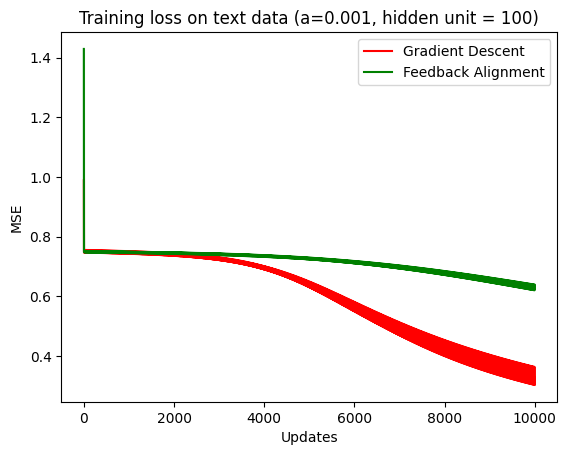

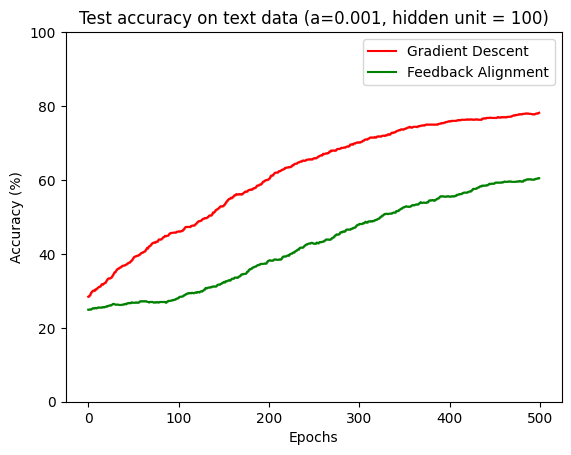

In [24]:
show_results([],[],losses_backprop_txt,accuracy_backprop_txt,losses_feedback_txt,accuracy_feedback_txt,numupdates,numepochs, "text",\
            learnrate,numhidden)


# Below sections are for image classification

In [18]:
# Load the MNIST dataset
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

print(train_set[0].shape)
print(valid_set[0].shape)
print(test_set[0].shape)

# Get the data into easy to use arrays
train_images = train_set[0][0:10000].transpose()
train_labels = np.zeros((10,10000))
for label in range(10000):
    train_labels[train_set[1][label],label] = 1
test_images = test_set[0][0:1000].transpose()
test_labels = np.zeros((10,1000))
for label in range(1000):
    test_labels[test_set[1][label],label] = 1


print(train_images.shape)
print(test_images.shape)

(50000, 784)
(10000, 784)
(10000, 784)
(784, 10000)
(784, 1000)


In [19]:
# convert np array to cp array if cuda is available
train_images = cnp.asarray(train_images)
train_labels = cnp.asanyarray(train_labels)

test_images = cnp.asarray(test_images)
test_labels = cnp.asarray(test_labels)

In [20]:
 # The part for perturbation method is commented out since this method is not very relevant for the research objective. It works, just need to uncomment

# numupdates = numepochs * int(np.floor(x_train_corpus.shape[1]/batchsize))
numupdates = numepochs * int(cnp.floor(train_images.shape[1]/batchsize))

print("total iteration to be run per training: ", numupdates)

# initialize the loss and accuracy holders
# losses_perturb_img  = cnp.zeros((numupdates,1))
losses_backprop_img = cnp.zeros((numupdates,1))
losses_feedback_img = cnp.zeros((numupdates,1))

accuracy_perturb_img  = cnp.zeros((numepochs,1))
accuracy_backprop_img = cnp.zeros((numepochs,1))
accuracy_feedback_img = cnp.zeros((numepochs,1))


# # create a network and train it using weight perturbation
# netperturb = MLP(train_images.shape[0], train_labels.shape[0], numhidden,batchsize,learnrate,alpha=initweight,algorithm='perturb',sigma=10)
# (losses_perturb_img[:,0],accuracy_perturb_img[:,0]) = \
# netperturb.train(train_images,train_labels,numepochs,test_images[:,:],test_labels[:,:],report=True, report_rate=1)

# create a network and train it using backprop
netbackprop = MLP(train_images.shape[0], train_labels.shape[0], numhidden,batchsize,learnrate,alpha=initweight,algorithm='backprop')
(losses_backprop_img[:,0],accuracy_backprop_img[:,0]) = \
netbackprop.train(train_images,train_labels,numepochs,test_images[:,:],test_labels[:,:],report=True, report_rate=1)

# # create a network and train it using feedback alignment
netfeedback = MLP(train_images.shape[0], train_labels.shape[0], numhidden,batchsize,learnrate,alpha=initweight,algorithm='feedback')
(losses_feedback_img[:,0],accuracy_feedback_img[:,0]) = \
netfeedback.train(train_images,train_labels,numepochs,test_images[:,:],test_labels[:,:],report=True, report_rate=1)

total iteration to be run per training:  10000
Training starting...
epoch  0  total number of batches is  20
...completed  1  epochs of training. Current loss:  0.8892664830403386 .
epoch  1  total number of batches is  20
...completed  2  epochs of training. Current loss:  0.8675206712816135 .
epoch  2  total number of batches is  20
...completed  3  epochs of training. Current loss:  0.8391573212243184 .
epoch  3  total number of batches is  20
...completed  4  epochs of training. Current loss:  0.8031694931875775 .
epoch  4  total number of batches is  20
...completed  5  epochs of training. Current loss:  0.7610574998806484 .
epoch  5  total number of batches is  20
...completed  6  epochs of training. Current loss:  0.7165039524292857 .
epoch  6  total number of batches is  20
...completed  7  epochs of training. Current loss:  0.6729010301642365 .
epoch  7  total number of batches is  20
...completed  8  epochs of training. Current loss:  0.6322117065399518 .
epoch  8  total numb

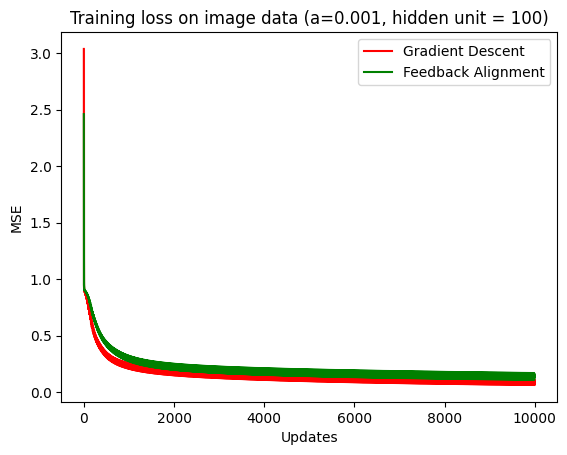

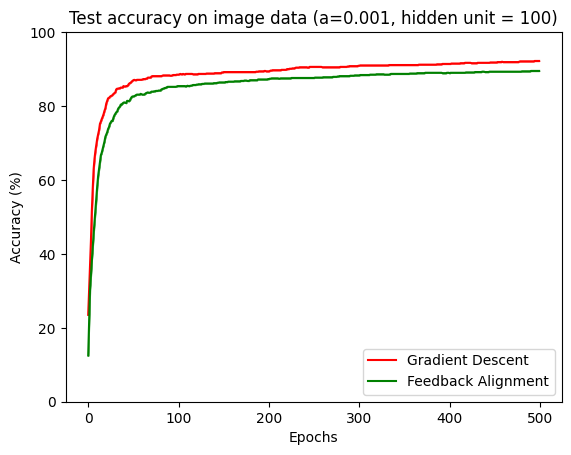

In [25]:
show_results([], [], losses_backprop_img, accuracy_backprop_img, losses_feedback_img, accuracy_feedback_img, numupdates, numepochs, "image",\
            learnrate,numhidden)

# Using a LogisticRegression linear model in Scikit-learn model for comparison

In [22]:
# for txt data
from sklearn.linear_model import LogisticRegression
lr_classifier = LogisticRegression(C=1)

lr_classifier.fit(x_train_tf.toarray(),tmp_train_l[0:10000])
predicted = lr_classifier.predict(x_test_tf.toarray())
print("\n The Accuracy on AG News Corpus with Logistic Regresion is ", str(np.mean(predicted == tmp_test_l[0:1000])), "\n")


 The Accuracy on AG News Corpus with Logistic Regresion is  0.814 



In [23]:
# for image data
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

train_images = train_set[0][0:10000]
tran_labels = train_set[1][0:10000]

test_images = test_set[0][0:1000]
test_labels = test_set[1][0:1000]


lr_classifier = LogisticRegression(C=1)
lr_classifier.fit(train_images,tran_labels)
predicted = lr_classifier.predict(test_images)
print("\n The Accuracy on MNIST with Logistic Regresion is ", np.mean(predicted == test_labels), "\n")


 The Accuracy on MNIST with Logistic Regresion is  0.882 



/home/felis/Programming/work/university/comp550/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
